# Proyecto Interconnet

La empresa de telecomunicaciones Interconnect requiere pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario planea irse:

- La empresa ofrecerá códigos promocionales
- Planes especiales.



**Servicios de Interconnect**

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

**Descripción de los datos**

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida hasta el 1 de febrero de 2020.

**Objetivo del proyecto**

Desarrollar un modelo de clasificación que pueda predecir si un cliente abandonará la compañía.



## Preprocesamiento de la información

### Importación de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer 
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### Carga de datos

In [2]:
data_contrato = pd.read_csv("/datasets/final_provider/contract.csv")
data_personal = pd.read_csv("/datasets/final_provider/personal.csv")
data_telefono = pd.read_csv("/datasets/final_provider/phone.csv")
data_internet = pd.read_csv("/datasets/final_provider/internet.csv")

**Revisión de los datos del DataFrame Contrato:**

In [3]:
data_contrato.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
def revision_datos(df):
    df.info()
    print("datos duplicados:", df.duplicated().sum())
    print("datos ausentes:", df.isna().sum())

In [5]:
revision_datos(data_contrato)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
datos duplicados: 0
datos ausentes: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


**De los datos entregados para contrato, se concluye:**

1. Hay 7043 registros distribuidos en 8 columnas. 
2. No hay datos faltantes.
3. No hay datos duplicados.
4. El nombre de las columnas aparecen con mayúsculas (no cumplen con la regla), por lo que se procederá a renombrarlas.
5. La mayor cantidad de las columnas son categóricas, solo "MonthlyCharges" es numérica.
6. La columna "BeginDate" es tipo object y se cambiará a Datetime.
7. La columna "TotalCharges" debe ser tipo float, por lo que se procederá al cambio.
8. La columna "EndDate" es tipo object pero debería ser Datetime para los clientes que ya se fueron(para poder calcular el tiempo que estuvieron contratando el servicio) y para los que aún se mantienen se podría colocar la fecha última que se tiene de datos: 01/02/2020. También se podría crear una columna que sea numérica para indicar que los clientes aún están activos (1) o ya no son clientes (0), esto pensando en un modelo de clasificación binaria.

In [6]:
#función para renombrar columnas
def cambio_nombre(df):
    columns = []
    for name in df.columns.values:
        name = re.sub("([A-Z])", r' \1', name).lower().replace(' ', '_')[1:]
        columns.append(name)
    df.columns = columns

In [7]:
data_contrato = data_contrato.rename(
    columns = {"customerID" : "CustomerId"})
cambio_nombre(data_contrato)
#verificación de los cambios en los nombres de columnas
data_contrato.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [8]:
#conversión de columnas string a numérica
data_contrato["total_charges"] = pd.to_numeric(data_contrato["total_charges"], errors = "coerce")
data_contrato["total_charges"] = data_contrato["total_charges"].astype ("float")

In [9]:
#conversión de columnas string a fecha
data_contrato["begin_date"] = pd.to_datetime(data_contrato["begin_date"], format="%Y-%m-%d")


In [10]:
data_contrato.describe()

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Text(0.5, 0, 'usd')

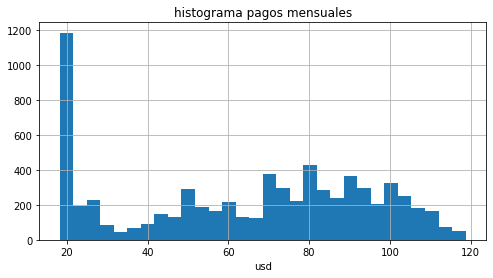

In [11]:
data_contrato["monthly_charges"].hist(bins=30, figsize=(8,4))
plt.title("histograma pagos mensuales")
plt.xlabel("usd")

Text(0.5, 0, 'usd')

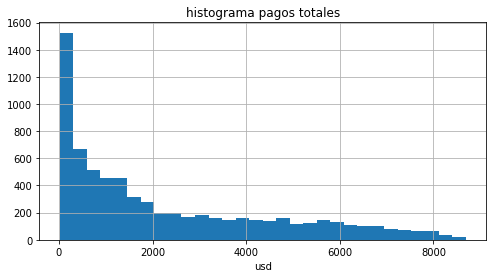

In [12]:
data_contrato["total_charges"].hist(bins=30, figsize=(8,4))
plt.title("histograma pagos totales")
plt.xlabel("usd")

La distribución de los datos de pagos mensuales muestra una asimetría negativa puesto que la mediana es mayor a la media con un pico fuerte entre los 18 y 25 usd aproximadamente. En cambio los datos de pagos totales muestra una asimetría positiva con la mayor concentración de datos entre 0 y 2000 usd.

<AxesSubplot:>

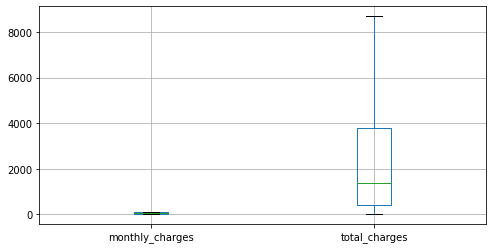

In [13]:
data_contrato.boxplot(figsize=(8,4))

Los diagrama de caja muestran que no hay datos atípicos.

In [14]:
data_contrato["type"].value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: type, dtype: float64

In [15]:
data_contrato["paperless_billing"].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: paperless_billing, dtype: float64

In [16]:
data_contrato["payment_method"].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: payment_method, dtype: float64

concluyendo:

1. Las columnas "type" , "payment_method" pueden ser transformadas de categóricas a numéricas con la codificación OHE

**Revisión de los datos del DataFrame Personal:**

In [17]:
data_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [18]:
revision_datos(data_personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
datos duplicados: 0
datos ausentes: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


**De los datos de personal:**

1. Hay 7043 registros con 5 columnas
2. No hay datos ausentes
3. No hay datos duplicados
4. La columna "senior_citizen" es numérica y el resto son categóricas, las cuales pueden ser transformadas más adelante a numéricas.
5. Los nombres de las columnas tienen mayúsculas sin separación, por lo que serán renombradas.

In [19]:
data_personal = data_personal.rename(
    columns = {"customerID" : "CustomerId",
              "gender": "Gender"})
cambio_nombre(data_personal)
data_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [20]:
data_personal["gender"].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

In [21]:
data_personal["senior_citizen"].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64

In [22]:
data_personal["partner"].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: partner, dtype: float64

In [23]:
data_personal["dependents"].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64

<AxesSubplot:>

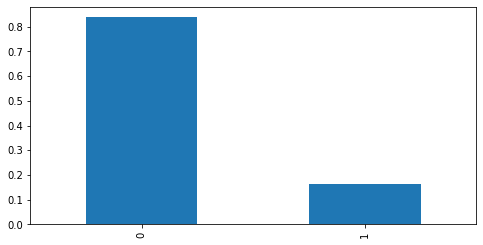

In [24]:
data_personal["senior_citizen"].value_counts(normalize=True).plot(kind="bar", figsize=(8,4))

Del histograma se aprecia que la mayor cantidad de clientes no son jubilados, solo el 16% corresponde a este rubro.

**Revisión del DataFrame Teléfono**

In [25]:
data_telefono.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
revision_datos(data_telefono)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
datos duplicados: 0
datos ausentes: customerID       0
MultipleLines    0
dtype: int64


**De los datos de la tabla telefono:**

1. Hay 6361 registros con 2 columnas
2. No hay datos ausentes
3. No hay datos duplicados
4. Las variables son categóricas.
5. El nombre de las columnas no cumple con la regla por lo que serán renombradas.
6. Se observa que el número de registros difiere de las tablas anteriores, por lo que se creará una columna para identificar, después de la unión de las tablas, cuales usuarios cuentan con el servicio telefónico y cuáles no.

In [27]:
#renombre de columnas
data_telefono = data_telefono.rename(
    columns = {"customerID" : "CustomerId"
              })
cambio_nombre(data_telefono)
data_telefono.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [28]:
data_telefono["multiple_lines"].unique()

array(['No', 'Yes'], dtype=object)

In [29]:
#creación de columna identificadora
data_telefono["usuario_telefono"] = "yes"

#verificación de la columna creada
data_telefono.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       6361 non-null   object
 1   multiple_lines    6361 non-null   object
 2   usuario_telefono  6361 non-null   object
dtypes: object(3)
memory usage: 149.2+ KB


**Revisión del DataFrame Internet:**

In [30]:
data_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [31]:
revision_datos(data_internet)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
datos duplicados: 0
datos ausentes: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


**De la tabla internet:**

1. Hay 5517 registros con 8 columnas
2. No hay datos ausentes
3. No hay datos duplicados
4. Los nombres de las columnas no cumplen con la regla por lo que serán renombradas
5. Todas las variables son categóricas y serán transformadas con OHE más adelante.
6. Se observa que el número de registros difiere de las tablas anteriores, por lo que se creará una columna para identificar, después de la unión de las tablas, cuales usuarios cuentan con el servicio telefónico y cuáles no.

In [32]:
#renombre de las columnas
data_internet = data_internet.rename(
    columns = {"customerID" : "CustomerId",
              "StreamingTV": "StreamingTv"})
cambio_nombre(data_internet)
data_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [33]:
#creación de la columna
data_internet["usuario_internet"]="yes"
data_internet["usuario_internet"].unique()

array(['yes'], dtype=object)

In [34]:
#Revisión de los valores unicos de de las columnas de la tabla de internet
columnas_internet_data = data_internet.drop("customer_id", axis=1)
columnas_internet_data = list(columnas_internet_data)
for j in columnas_internet_data:
    print(j, ":", data_internet[j].unique())

internet_service : ['DSL' 'Fiber optic']
online_security : ['No' 'Yes']
online_backup : ['Yes' 'No']
device_protection : ['No' 'Yes']
tech_support : ['No' 'Yes']
streaming_tv : ['No' 'Yes']
streaming_movies : ['No' 'Yes']
usuario_internet : ['yes']


**Unión de las tablas:**

se procederá a realizar el emparejamiento de las tablas por medio de la columna customer_id.

In [35]:
data_2 = pd.merge(pd.merge(data_personal, data_telefono, on="customer_id", how="outer"), data_internet, on="customer_id", how="outer")
data_completa = pd.merge(data_2, data_contrato, on="customer_id", how="outer")
data_completa.head(5)

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,usuario_telefono,internet_service,online_security,online_backup,...,streaming_tv,streaming_movies,usuario_internet,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,Female,0,Yes,No,NaN,NaN,DSL,No,Yes,...,No,No,yes,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,No,yes,DSL,Yes,No,...,No,No,yes,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,No,yes,DSL,Yes,Yes,...,No,No,yes,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,NaN,NaN,DSL,Yes,No,...,No,No,yes,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,No,yes,Fiber optic,No,No,...,No,No,yes,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [36]:
revision_datos(data_completa)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   int64         
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   multiple_lines     6361 non-null   object        
 6   usuario_telefono   6361 non-null   object        
 7   internet_service   5517 non-null   object        
 8   online_security    5517 non-null   object        
 9   online_backup      5517 non-null   object        
 10  device_protection  5517 non-null   object        
 11  tech_support       5517 non-null   object        
 12  streaming_tv       5517 non-null   object        
 13  streaming_movies   5517 non-null   object        
 14  usuario_

**De la tabla unificada:**

1. Se obtuvo un DataFrame con 7043 registros y 22 columnas.
2. Aparecen, como era de esperarse después de la fusión, 682 datos ausentes para la columnas provenientes de la tabla data_telefono, debido a que esta contenía solo 6361 registros en lugar de 7043.
3. Hay 1526 datos ausentes en los datos provenientes de la tabla de internet.
4. La columna "total_charges" presenta 11 datos ausentes.
5. No hay datos duplicados.
6. La columna "customer_id" no será de interés en el modelo de machine learning por lo que puede ser eliminada.
7. Se creará la columna "antiguedad" para determinar que tiempo lleva un usuario con el servicio.
8. Se identifica el target como la columna end_date pero transformada a datos numéricos, donde 1: activo y 0: inactivo.
9. Las columnas de "begin_date" y "end_date", no realizarán ningún aporte al modelo de machine learning por lo que, al igual que "customer_id" serán eliminadas.

In [37]:
#determinación de la antiguedad de los clientes en interconnet:
fecha_actual = pd.to_datetime("2020-02-01")
data_completa["antiguedad"] = (fecha_actual - data_completa["begin_date"]).dt.days


In [38]:
#función para definir el target en variables numéricas (1 activo y 0 que se fue):
def target(end_date):
    if end_date == "No":
        return 1
    return 0
    

In [39]:
#creación de la columna target en el DataFrame:
data_completa["target"] = data_completa["end_date"].apply(target)

In [40]:
data_completa["target"].value_counts(normalize=True)

1    0.73463
0    0.26537
Name: target, dtype: float64

In [41]:
#conversión de datos string a fecha
data_completa.loc[data_completa["end_date"]=="No", "end_date"] = "2020-02-01 00:00:00"
data_completa["end_date"] = pd.to_datetime(data_completa["end_date"], format="%Y-%m-%d %H:%M:%S")
data_completa["end_date"].value_counts(normalize=True)

2020-02-01    0.734630
2019-11-01    0.068863
2019-12-01    0.066165
2020-01-01    0.065313
2019-10-01    0.065029
Name: end_date, dtype: float64

<AxesSubplot:>

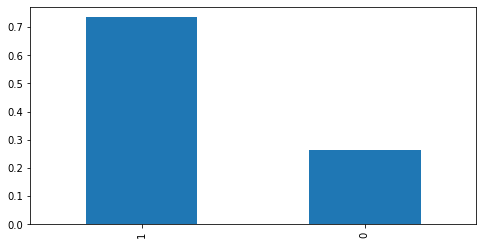

In [42]:
data_completa["target"].value_counts(normalize=True).plot(kind="bar", figsize=(8,4))

In [43]:
data_completa["antiguedad"].min()

0

In [44]:
data_completa["antiguedad"].value_counts()

2191    366
153     237
123     237
92      237
31      233
       ... 
0        11
2222      7
2253      3
2314      3
2283      2
Name: antiguedad, Length: 77, dtype: int64

In [45]:
#Al observar la columna antiguedad, se aprecia que el usuario con menor antiguedad tiene 0 días, acaba de empezar como cliente
data_completa[(data_completa["total_charges"].isna()) & (data_completa["antiguedad"]==0)]

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,usuario_telefono,internet_service,online_security,online_backup,...,usuario_internet,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,antiguedad,target
488,4472-LVYGI,Female,0,Yes,Yes,NaN,NaN,DSL,Yes,No,...,yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,1
753,3115-CZMZD,Male,0,No,Yes,No,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,1
936,5709-LVOEQ,Female,0,Yes,Yes,No,yes,DSL,Yes,Yes,...,yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,1
1082,4367-NUYAO,Male,0,Yes,Yes,Yes,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,1
1340,1371-DWPAZ,Female,0,Yes,Yes,NaN,NaN,DSL,Yes,Yes,...,yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,1
3331,7644-OMVMY,Male,0,Yes,Yes,No,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,1
3826,3213-VVOLG,Male,0,Yes,Yes,Yes,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,1
4380,2520-SGTTA,Female,0,Yes,Yes,No,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,1
5218,2923-ARZLG,Male,0,Yes,Yes,No,yes,NaN,NaN,NaN,...,NaN,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,1
6670,4075-WKNIU,Female,0,Yes,Yes,Yes,yes,DSL,No,Yes,...,yes,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,1


En la columna "total_charges" se verifica que los 11 registros ausentes:

1. Se corresponden con los 11 registros de antiguedad 0
2. Se corresponden con "begin_date" igual a 2020-02-01
3. son todos clientes activo (target = 1)
4. Todos tienen datos de "monthly_charges", valores que servirán para la imputación, dado que se asume el precio de la tarifa contratada.

In [46]:
#Se reemplazan esos datos ausentes en total_charges por los de monthly_charges
data_completa.loc[data_completa["total_charges"].isna(), "total_charges"]= data_completa["monthly_charges"]

In [47]:
#verificación de la imputación de los valores ausentes
data_completa[data_completa["total_charges"].isna()]

,customer_id,gender,senior_citizen,partner,dependents,multiple_lines,usuario_telefono,internet_service,online_security,online_backup,...,usuario_internet,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,antiguedad,target


Las columnas que muestran datos faltantes en su mayoría, a excepción de "internet_service" son de "yes" or "no", por lo que se infiere que al tener datos ausentes es porque no cuentan con el servicio, por lo que se procederá a imputar con "No". La columna de "internet_service" se imputará con "ninguno"

In [48]:
#imputación de datos ausentes
data_completa["internet_service"] = data_completa["internet_service"].fillna("ninguno")
data_completa = data_completa.fillna("No")


In [49]:
data_completa.isna().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
usuario_telefono     0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
usuario_internet     0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
antiguedad           0
target               0
dtype: int64

In [50]:
data_completa["internet_service"].unique()

array(['DSL', 'Fiber optic', 'ninguno'], dtype=object)

In [51]:
data_completa.shape

(7043, 24)

In [52]:
#eliminación de las columnas de fecha y customer_id:
data_completa = data_completa.drop(["customer_id", "begin_date", "end_date"], axis=1)


In [53]:
#verificación de que se eliminaron las columnas del DataFrame
data_completa.shape

(7043, 21)

## Análisis Exploratorio de Datos

Se identificó a la columna "end_date" como target transformada a columna numérica, por lo que a continuación de realizará la revisión del target y su relación con otras variables.

### Revisión variables categóricas

In [54]:
#función para crear gráficos de barras para las columnas categóricas
def grafico_target_categorico(df, col):
    g_col_0 = df.query('target==0').pivot_table(index=col, values="target", aggfunc="count")
    g_col_1 = df.query('target==1').pivot_table(index=col, values="target", aggfunc="count")
    g_col=g_col_0.merge(g_col_1, on=col)
    g_col = g_col.rename(columns={"target_x":"clientes_inactivos",
                         "target_y": "clientes_activos"})
    g_col.plot(kind="bar", figsize=(8,6), stacked = 'True', alpha=0.6, width = 0.6, title="Distribucion por target")
    

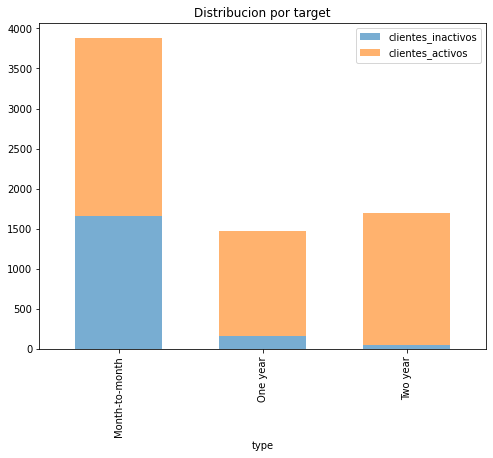

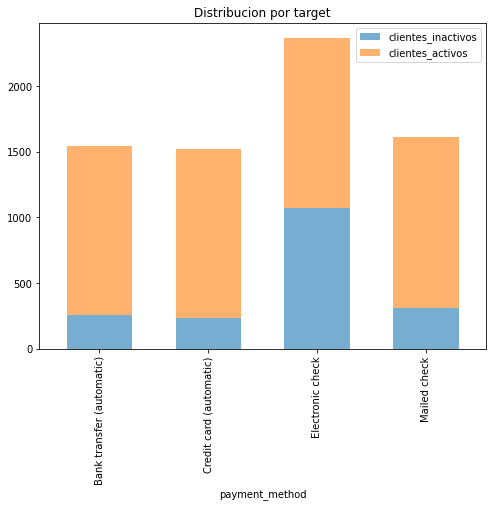

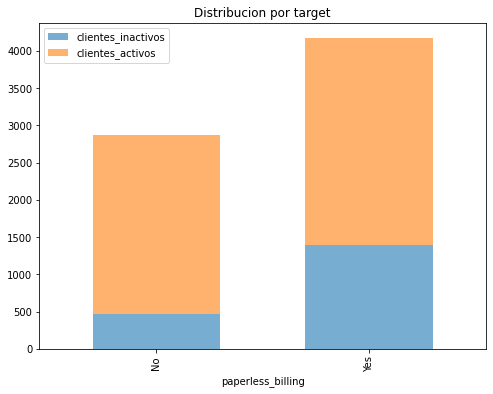

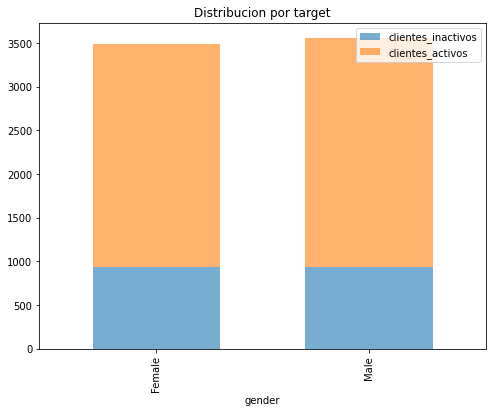

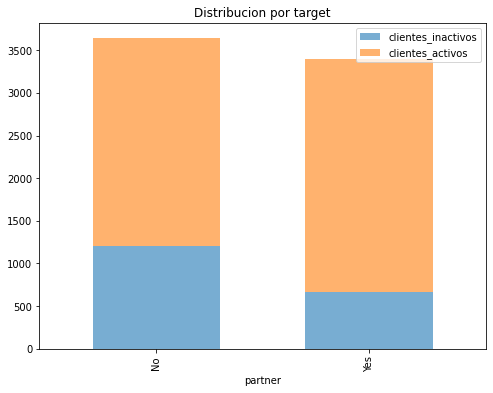

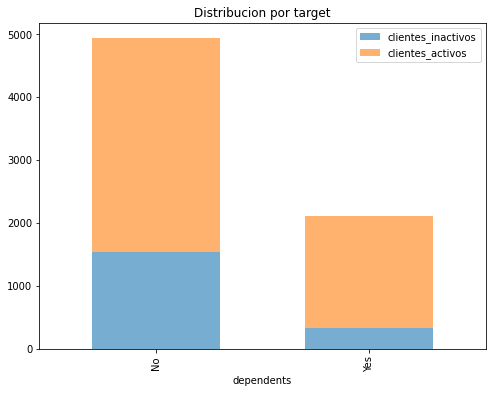

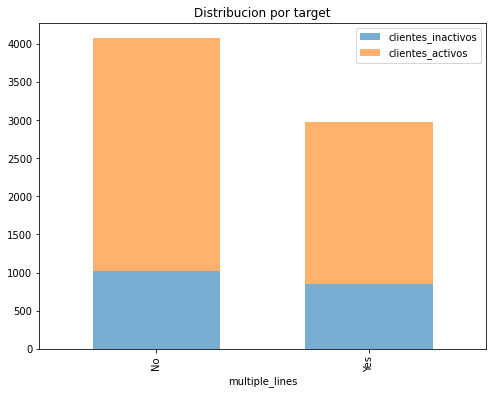

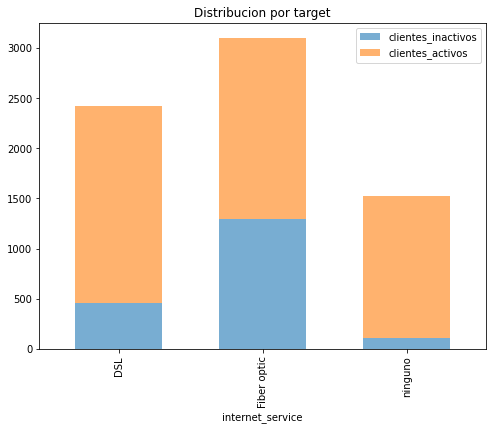

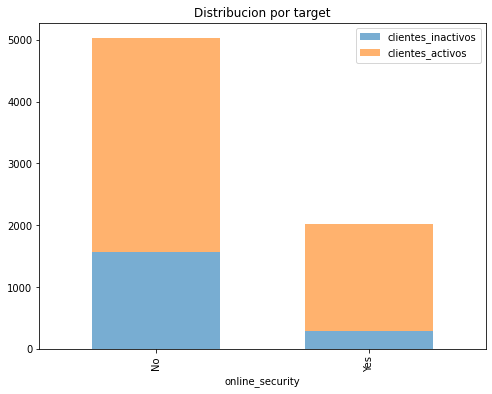

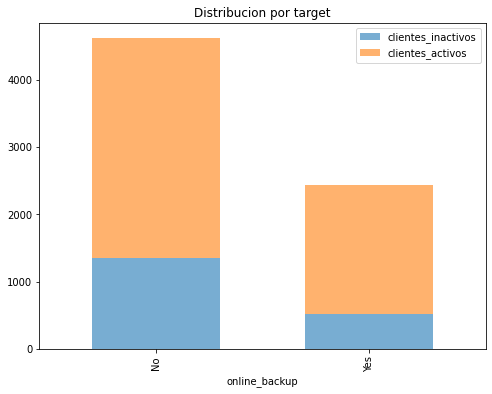

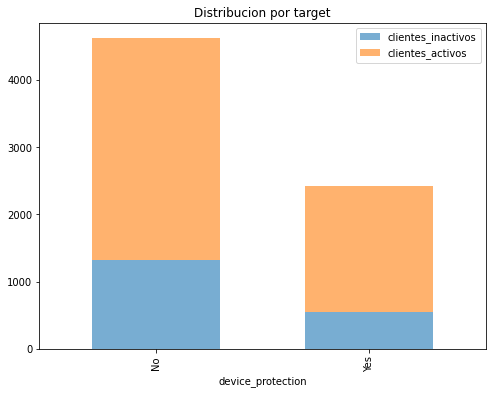

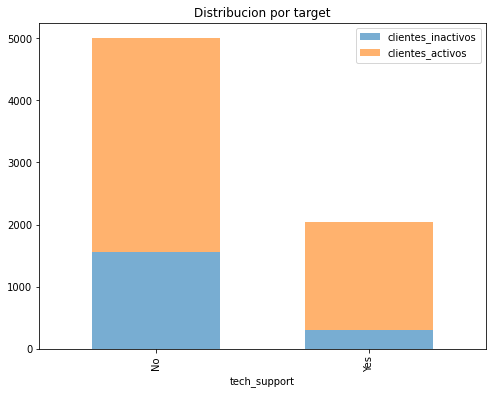

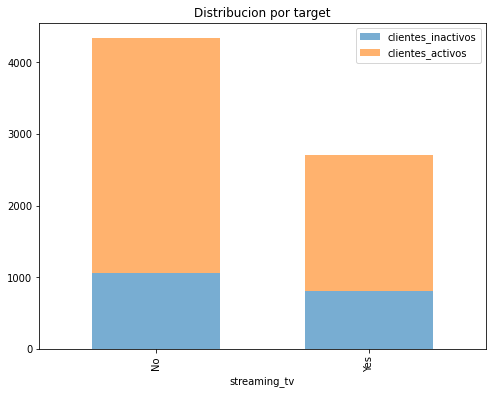

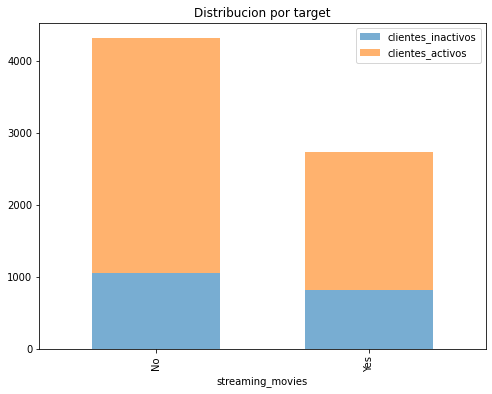

In [55]:
columns_grafico = ["type", "payment_method", "paperless_billing", "gender", "partner", "dependents",
                   "multiple_lines", "internet_service", "online_security", "online_backup", 
                  "device_protection", "tech_support", "streaming_tv", "streaming_movies"]
for j in columns_grafico:
    grafico_target_categorico(data_completa, j)


In [56]:
#calculo chi2 para revisar relación de variables categóricas con el target
p_values_col = []
columnas_chi2 = []
for t in columns_grafico:
    
    c, p, dof, expected = chi2_contingency(pd.crosstab(data_completa[t], data_completa["target"], margins=False))
    columnas_chi2.append(t)
    p_values_col.append(p)
    

p_values_tabla = pd.DataFrame({"p_value": p_values_col}, index=columnas_chi2)
p_values_tabla
    

,p_value
type,5.863038e-258
payment_method,3.682355e-140
paperless_billing,4.073355e-58
gender,4.865787e-01
partner,2.139911e-36
dependents,4.924922e-43
multiple_lines,8.433795e-04
internet_service,9.571788e-160
online_security,1.232098e-46
online_backup,6.214093e-12


**De las variables categóricas:**

1. El tipo de contratación predominante en ambos grupos es el de mes x mes, ya contrato por 2 años le sigue a los actuales clientes , mientras que en los clientes que se fueron ocupan la tercera posición.
2. Los clientes actuales utilizan por igual los 4 métodos de pago de su factura, mientrás que grupo que se fue usaba predominantemente los cheques electrónicos como medio de pago.
3. La mayoría de los clientes aceptaron el envío de factura por otro medio distinto al papel.
4. La mayoría de los clientes, tanto los actuales como los que se fueron, no usan múltiples líneas y son usuarios de teléfono.
5. No hay diferencia con el género y los grupos de activo e inactivo, es decir, practicamente es igual la cantidad de hombre como de mujeres que contratan los servicios de interconnet.
6. La mayoría de los clientes que se fueron no tenían pareja ni dependientes, mientrás que los que se mantienen como clientes mayormente tienen pareja.
7. En ambos grupos analizados la mayor cantidad de clientes no están jubilados.
8. La mayor cantidad de clientes (tanto activos como los que se fueron) no usan los servicios adicionales brindados por Interconnect, es decir: seguridad en internet, almacenamiento de archivos en la nube y backup de datos, bloqueador de sitios web maliciosos, streaming_tv, streaming_movies. 
9. La configuración del internet que usan los clientes actuales es en su mayoría DSL mientrás que los que se fueron usaban fibra óptica.
10. Del análisis de chi cuadrado se obtiene que P-value es menor a 0.05 lo que indica que si hay relación de las variables categóricas estudiadas con el target.

### Revisión variables numéricas

In [57]:
#funcion para generar gráficos de variables numéricas
def grafico_target_numerico(df, col):
    sns.histplot(data=df, x=col, hue="target")

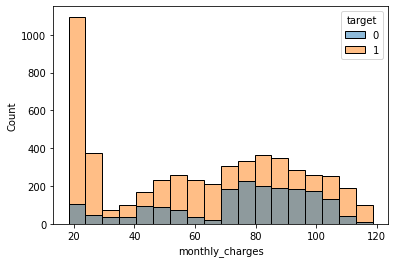

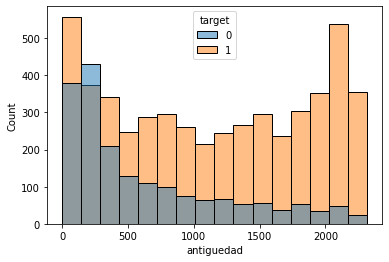

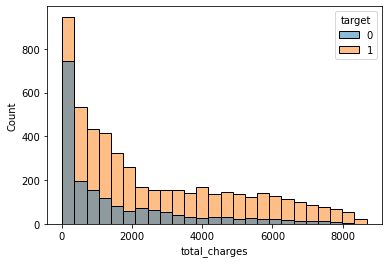

In [58]:
col_numerica_data = ["monthly_charges", "antiguedad", "total_charges"]
for k in col_numerica_data:
    grafico_target_numerico(data_completa, k)
    plt.show()
    

In [59]:
#pagos mensuales discretizado por el target
mensual_activo = data_completa.query('target == 1')
mensual_inactivo = data_completa.query('target == 0')

In [60]:
def funcion_estadistica(df, df2, columna_1, columna_2):
    p1 = df[columna_1].describe() 
    p2 = df2[columna_1].describe()
    p3 = df[columna_2].describe()
    p4 = df2[columna_2].describe()
    d = pd.concat([p1, p2, p3, p4], axis=1)
    d.columns = ["cargo mensual clientes activos", "cargo mensual clientes inactivos", "antiguedad activos", "antiguedad inactivos"]
    return d


In [61]:
funcion_estadistica(mensual_activo, mensual_inactivo, "monthly_charges", "antiguedad")

,cargo mensual clientes activos,cargo mensual clientes inactivos,antiguedad activos,antiguedad inactivos
count,5174.000000,1869.000000,5174.000000,1869.000000
mean,61.265124,74.441332,1144.447236,624.455324
std,31.092648,24.666053,733.897937,595.910567
min,18.250000,18.850000,0.000000,62.000000
25%,25.100000,56.150000,457.000000,153.000000
50%,64.425000,79.650000,1157.000000,365.000000
75%,88.400000,94.200000,1857.000000,945.000000
max,118.750000,118.350000,2191.000000,2314.000000


**De las variables numéricas, se observa que:**

1. El monto mensual de facturación de los clientes actuales muestra un pico fuerte alrededor de los 25 usd mientras que para los clientes que se fueron estaban entre los 75 y 85 usd. De la tabla estadística se aprecia que para el 25% de los clientes actuales el monto mensual está alrededor de los 25 usd mientrás que para los clientes inactivos es un poco más del doble (56 usd), aunque los máximos y mínimos para ambos clientes son similares, la mediana en el grupo de los inactivos supera en 15 usd a los clientes actuales.
2. La mayoría de los clientes que se fueron de Interconnect tenían poca antiguedad, menor a 400 días, la mediana de este grupo es de 365, mientrás que para los actuales clientes es prácticamente el triple. 


In [62]:
#match de tantos clientes que usan internet como clientes que usan telefono
servicio_general_clientes = data_completa.query('usuario_internet == "yes" and usuario_telefono == "yes"')
servicio_internet = data_completa.query('usuario_internet == "yes"')
servicio_telefono = data_completa.query('usuario_telefono == "yes"')

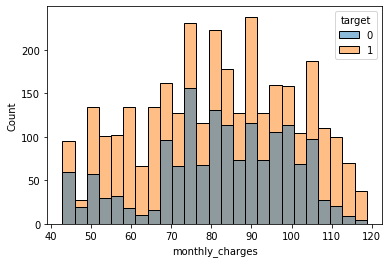

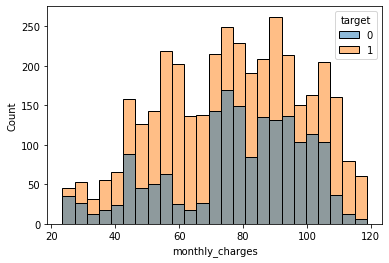

<AxesSubplot:xlabel='monthly_charges', ylabel='Count'>

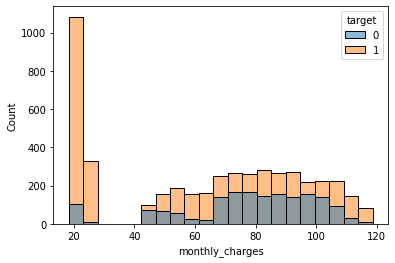

In [63]:
sns.histplot(data=servicio_general_clientes, x="monthly_charges", hue="target")
plt.show()
sns.histplot(data=servicio_internet, x="monthly_charges", hue="target")
plt.show()
sns.histplot(data=servicio_telefono, x="monthly_charges", hue="target")

In [64]:
def funcion_estadistica_2(df, df2, df3, columna):
    p1 = df[columna].describe() 
    p2 = df2[columna].describe()
    p3 = df3[columna].describe()
    d = pd.concat([p1, p2, p3], axis=1)
    d.columns = ["clientes telefono", "clientes internet", "clientes ambos servicios"]
    return d

In [65]:
funcion_estadistica_2(servicio_telefono, servicio_internet, servicio_general_clientes, "monthly_charges")

,clientes telefono,clientes internet,clientes ambos servicios
count,6361.000000,5517.000000,4835.000000
mean,67.199041,76.844254,81.755171
std,30.449604,21.924661,18.303085
min,18.250000,23.450000,42.900000
25%,44.750000,59.950000,69.775000
50%,74.700000,79.450000,82.500000
75%,91.250000,94.450000,95.700000
max,118.750000,118.750000,118.750000


In [66]:
data_completa.corr()

,senior_citizen,monthly_charges,total_charges,antiguedad,target
senior_citizen,1.000000,0.220173,0.102997,0.023454,-0.150889
monthly_charges,0.220173,1.000000,0.651182,0.260860,-0.193356
total_charges,0.102997,0.651182,1.000000,0.829402,0.198347
antiguedad,0.023454,0.260860,0.829402,1.000000,0.311715
target,-0.150889,-0.193356,0.198347,0.311715,1.000000


<AxesSubplot:>

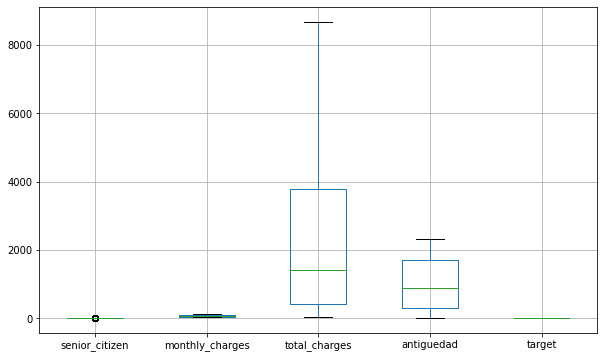

In [67]:
data_completa.boxplot(figsize=(10,6))

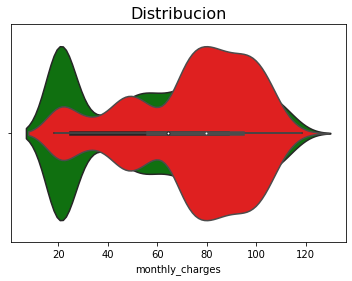

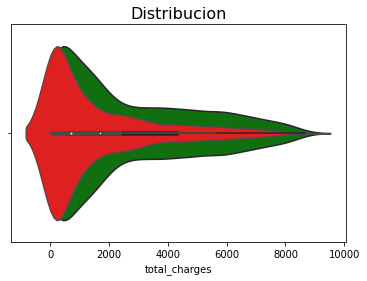

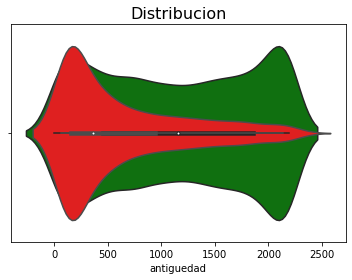

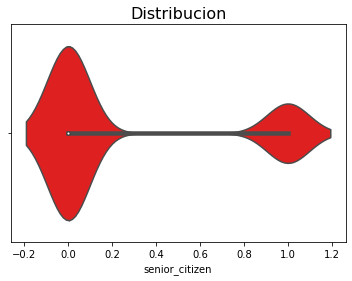

In [75]:
data_violin_activo = data_completa.query('target==1')
data_violin_no_activo = data_completa.query('target==0')

numerica_variable = ["monthly_charges", "total_charges", "antiguedad", "senior_citizen"]
for v in numerica_variable:
    ax = sns.violinplot(x=data_violin_activo[v], color="green")
    ax = sns.violinplot(x=data_violin_no_activo[v], color="red")
    ax.set_title("Distribucion", fontsize=16)
    plt.show()

**De estas últimas gráficas se observa:**
1. Los clientes que se fueron pagaban mensualmente entre 70 y 110 usd por concepto de internet, teléfono y ambos servicios, la distribución de los datos es muy marcada en estos puntos.
2. Los usuarios activos actualmente muestran que para ambos servicios la distribución se hace más uniforme para todos los precios y en el caso de solo teléfono aparece muy marcado un pico entre los 20 y 25 usd.
3. Los datos estadísticos muestran que al tener contratado tanto el teléfono como el internet, la media, mínimo y mediana es mucho mayor, como ejemplo para un 25% los clientes q tienen solo teléfono pagan 45 usd, con solo internet 60 usd y con ambos 70 usd.
4. 6361 clientes son usuarios de teléfono, 5517 de internet y 4835 pagan por ambos servicios.
5. Hay una relación negativa entre el target y "senior_citizen" y "monthly_charges", mientras que el target se relaciona de manera positiva con "total_charges" y "antiguedad".
6. Los gráficos de violin y boxplot corroboran lo antes expuesto.


**En conclusión:**

1. La mayor cantidad de clientes que se fueron pagaban montos mensuales muy altos en comparación con los clientes actuales.
2. Los clientes que se fueron presentaban poca antiguedad en Interconnet
3. Tantos los clientes actuales como los que se fueron no usan los servicios adicionales que ofrece Interconnect tanto en la línea telefónica(multiples líneas) como en el servicio de internet(seguridad en internet, almacenamiento de archivos en la nube y backup de datos, bloqueador de sitios web maliciosos, streaming_tv, streaming_movies).
4. La mayor cantidad de clientes que se fueron tenían configurado su internet por fibra óptica, no tenían parejas y pagaban por cheques electrónicos
5. Es posible que estos clientes que se fueron, encontraron otra compañia que les permite diseñar su plan de acuerdo a sus necesidades, como planes de menor precio que no incluya los servicios adicionales y sean más atractivos para este grupo de clientes.
6. Todas las variables categóricas tienen relación con el target, por lo que se integrarán en la construcción del modelo de machine learning.
7. Hay variables que se ven desequilibradas por lo que se tendrá que aplicar escalamiento.

## Plan de Trabajo 

**Para continuar con el desarrollo del proyecto (modelo de machine learning de clasificación), estimo continuar con los siguientes pasos:**

1. Aplicar codificación One-Hot para transformar las características categóricas en numéricas(casi todas son de yes or no, por lo que no se deben agregar muchas columnas): 
   pd.get_dummies(data, drop_first=True)
2. Aplicar escalado de las features por el desequilibrio que hay:
   scaler = StandardScaler()
3. Realizar el split de features y target en datos de entrenamiento(60%), validación(20%) y prueba(20%):
   train_test_split()
4. Definir función para las métricas que mejore la eficiencia del modelo (F1, mae).
5. Entrenar diferentes modelos(LogisticRegression, RandomForest, DecisionTree, LGBM) con ajuste de hiperparámetros y evaluarlos en el conjunto de datos de validación y prueba.
6. Comparar los modelos y concluir.

###  Transformación de features

Se procede a transformar las 17 features categóricas en numéricas para su modelaje.

In [76]:
data_completa.shape

(7043, 21)

In [77]:
data_completa.dtypes

gender                object
senior_citizen         int64
partner               object
dependents            object
multiple_lines        object
usuario_telefono      object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
usuario_internet      object
type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
antiguedad             int64
target                 int64
dtype: object

In [78]:
#previo a la conversion se tienen 21 columnas en el DataFrame, se convertiran en total 16 columnas categóricas
# se agrupan a columns_one_hot las 16 columnas categóricas que forman parte del DataFrame
columns_one_hot = ["type", "paperless_billing", "payment_method", "gender", "partner", "dependents", "multiple_lines",
                   "usuario_telefono", "internet_service", "online_security", "online_backup", "device_protection", 
                  "tech_support", "streaming_tv", "streaming_movies", "usuario_internet"]
data_completa = pd.get_dummies(data_completa, columns = columns_one_hot, drop_first = True)

In [79]:
data_completa.shape

(7043, 25)

In [80]:
data_completa.dtypes

senior_citizen                              int64
monthly_charges                           float64
total_charges                             float64
antiguedad                                  int64
target                                      int64
type_One year                               uint8
type_Two year                               uint8
paperless_billing_Yes                       uint8
payment_method_Credit card (automatic)      uint8
payment_method_Electronic check             uint8
payment_method_Mailed check                 uint8
gender_Male                                 uint8
partner_Yes                                 uint8
dependents_Yes                              uint8
multiple_lines_Yes                          uint8
usuario_telefono_yes                        uint8
internet_service_Fiber optic                uint8
internet_service_ninguno                    uint8
online_security_Yes                         uint8
online_backup_Yes                           uint8


Despues de la conversión se obtuvo un DataFrame:
1. 25 columnas, 4 columnas más que el original. 
2. Aparecen características o variables nuevamente con letras mayúsculas en su nombre, por lo que deben ser renombradas.
3. Las características transformadas aparecen como uint8.


In [81]:
#cambio_nombre
def cambio_nombre_1(df):
    columns = []
    for name in df.columns.values:
        name = re.sub("([A-Z])", r' \1', name).lower().replace(' ', '_')[0:]
        columns.append(name)
    df.columns = columns


In [82]:
cambio_nombre_1(data_completa)

In [83]:
data_completa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   senior_citizen                           7043 non-null   int64  
 1   monthly_charges                          7043 non-null   float64
 2   total_charges                            7043 non-null   float64
 3   antiguedad                               7043 non-null   int64  
 4   target                                   7043 non-null   int64  
 5   type__one_year                           7043 non-null   uint8  
 6   type__two_year                           7043 non-null   uint8  
 7   paperless_billing__yes                   7043 non-null   uint8  
 8   payment_method__credit_card_(automatic)  7043 non-null   uint8  
 9   payment_method__electronic_check         7043 non-null   uint8  
 10  payment_method__mailed_check             7043 no

### Escalado de las features

In [84]:
def funcion_min_max(df, columna_1, columna_2, columna_3):
    d1_min = df[columna_1].min() 
    d1_max = df[columna_1].max()
    d2_min = df[columna_2].min() 
    d2_max = df[columna_2].max()
    d3_min = df[columna_3].min() 
    d3_max = df[columna_3].max()
    resul=pd.DataFrame({"features": ["monhtly_charges", "total_charges", "antiguedad"],
                 "min": [d1_min, d2_min, d3_min],
                 "max": [d1_max, d2_max, d3_max]})
    
    return resul

In [85]:
funcion_min_max(data_completa, "monthly_charges", "total_charges", "antiguedad")

,features,min,max
0,monhtly_charges,18.25,118.75
1,total_charges,18.80,8684.80
2,antiguedad,0.00,2314.00


Como se observa, el rango de variación de las features numéricas es amplio por lo que se procedera a standarizar para darle el mismo peso de importancia.

In [86]:
scaler = StandardScaler()
numeric_columns = ["monthly_charges", "total_charges", "antiguedad"]
data_completa[numeric_columns] = pd.DataFrame(scaler.fit_transform(data_completa[numeric_columns]))

In [87]:
data_completa.head()

,senior_citizen,monthly_charges,total_charges,antiguedad,target,type__one_year,type__two_year,paperless_billing__yes,payment_method__credit_card_(automatic),payment_method__electronic_check,...,usuario_telefono_yes,internet_service__fiber_optic,internet_service_ninguno,online_security__yes,online_backup__yes,device_protection__yes,tech_support__yes,streaming_tv__yes,streaming_movies__yes,usuario_internet_yes
0,0,-1.160323,-0.992667,-1.324370,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1
1,0,-0.259629,-0.172198,0.040110,1,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0,1
2,0,-0.362660,-0.958122,-1.199462,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
3,0,-0.746535,-0.193706,0.494937,1,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,1
4,0,0.197365,-0.938930,-1.158732,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,1


### Segmentación de datos

In [88]:
#definición de features y target
features = data_completa.drop(["target"], axis=1)
target = data_completa["target"]

#segmentación de los datos para entrenamiento 
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.40, random_state=12345)

In [89]:
#segmentación de datos para validación y prueba
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)

In [90]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(4225, 24)
(1409, 24)
(1409, 24)
(4225,)
(1409,)
(1409,)


### Definicion de funcion para evaluacion del modelo y metrica

In [91]:
#función para definir métricas de evaluación

def metricas_evaluacion(target, predict, predict_proba):
    f1_metric = f1_score(target, predict)
    recall_metric = recall_score(target, predict)
    precision_metric = precision_score(target, predict)
    auc_roc_metric = roc_auc_score(target, predict_proba)
    
    #print(confusion_matrix(target, predict))
    cm = confusion_matrix(target, predict)
    sns.heatmap(cm, annot=True, cmap="summer")
    plt.show()
    
    return f1_metric, recall_metric, precision_metric, auc_roc_metric

r_scorer = make_scorer(metricas_evaluacion, greater_is_better=False)

In [92]:
#función para graficar AUC-ROC y precision vs recall
def grafica_metrica_modelo(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
         
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # ROC
        ax = axs[0]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[1]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

   
    return

In [93]:
#función para evaluar el modelo
def modelo(model, x_train, y_train, x_valid, y_valid, hiperparametros={}, scoring=None, cv=5, verbose=False):
    np.random.seed(42)
        
    #afinamiento de hiperparámetros
    gridsearch = GridSearchCV(model, param_grid=hiperparametros, scoring=scoring, cv=cv)
    gridsearch.fit(x_train, y_train)
    
    #ajuste del modelo con los mejores hiperparámetros
    gridsearch.best_estimator_.fit(x_train, y_train)
   
    #predicción
    prediccion = gridsearch.best_estimator_.predict(x_valid)
    prediccion_proba = gridsearch.best_estimator_.predict_proba(x_valid)[:, 1]
    f1_metric, recall_metric, precision_metric, auc_roc_metric = metricas_evaluacion(y_valid, prediccion, prediccion_proba)
    resultado_metrica = pd.DataFrame({"metrica": ["f1", "recall", "precision", "AUC-ROC"],
                                     "valid": [f1_metric, recall_metric, precision_metric, auc_roc_metric]})
    grafica_metrica_modelo(gridsearch.best_estimator_, x_train, y_train, x_valid, y_valid)
    
    return gridsearch.best_estimator_, f1_metric, recall_metric, precision_metric, auc_roc_metric, resultado_metrica
    

### Modelo Logistic Regression

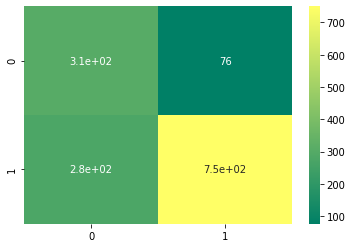

,metrica,valid
0,f1,0.809498
1,recall,0.730282
2,precision,0.907990
3,AUC-ROC,0.845364


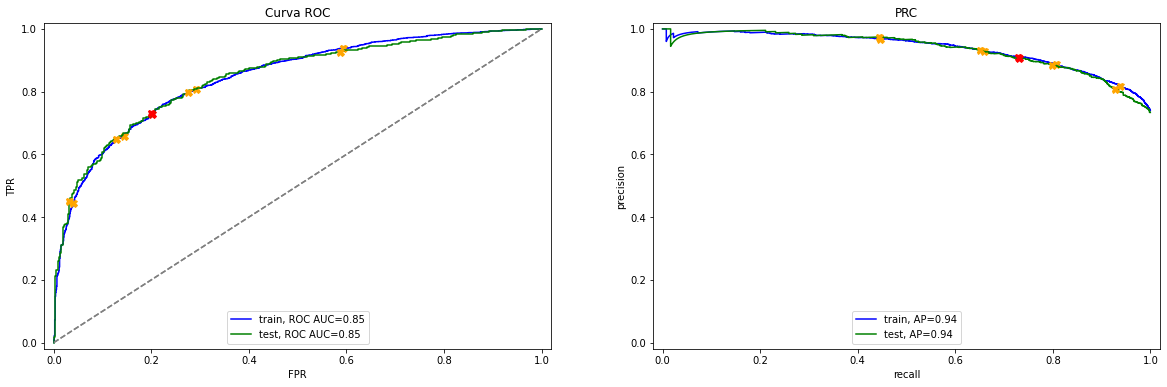

In [94]:
lr = LogisticRegression(random_state=12345, class_weight="balanced", penalty='l1', solver="liblinear")
lr_model, f1_metric_lr, recall_metric_lr, precision_metric_lr, auc_roc_metric_lr, result_lr  = modelo(lr, features_train, target_train, features_valid, target_valid, hiperparametros={}, scoring=r_scorer, cv=5)
result_lr

**Observaciones:**
1. De acuerdo a la matriz de confusión el modelo predice con un 73% los clientes que se mantienen activos, es decir, de los 1027 casos el modelo acierta 750 veces y tiene una precision de 91%.
2. La curva AUC-ROC muestra que hay un 85% de probabilidad de que el modelo Logistic Regression pueda distinguir entre los 2 valores del target

### Modelo Random Forest

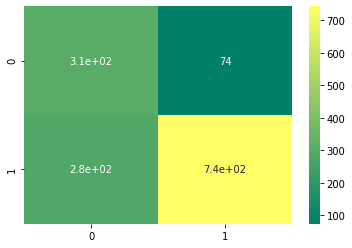

,metrica,valid
0,f1,0.805857
1,recall,0.723466
2,precision,0.909425
3,AUC-ROC,0.831742


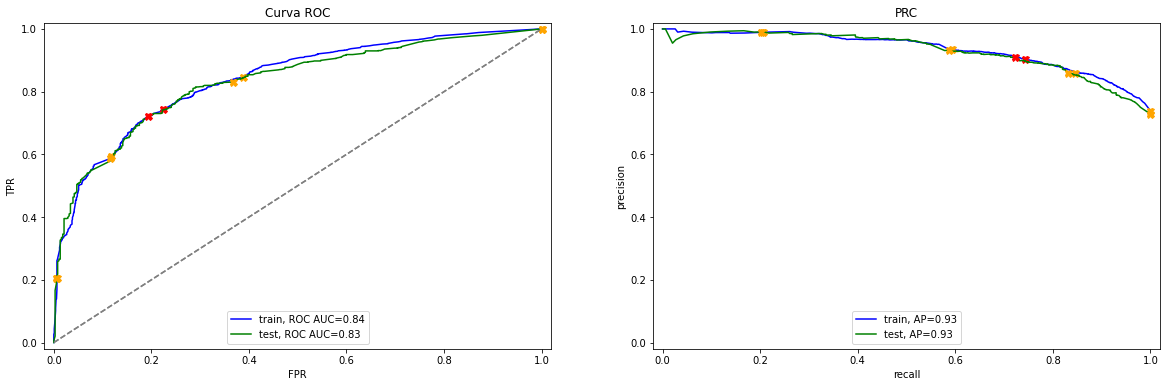

In [95]:
rf = RandomForestClassifier(random_state=12345, class_weight="balanced")
hiper_rf = {"n_estimators": range(10,100,10), "max_depth" : range(4,32,4),"min_samples_split": range(2, 8, 2),
           "min_samples_leaf" : range(2, 10, 2), "max_leaf_nodes":[6, 12]}
rf_model, f1_metric_rf, recall_metric_rf, precision_metric_rf, auc_roc_metric_rf, result_rf = modelo(rf, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_rf, scoring=r_scorer, cv=5)
result_rf

In [148]:
rf_model

RandomForestClassifier(class_weight='balanced', max_depth=4, max_leaf_nodes=6,
                       min_samples_leaf=2, n_estimators=5, random_state=12345)

**Observaciones:**
1. El modelo es capaz de reproducir en un 72% los valores de target 1.
2. La curva AUC-ROC muestra que probablemente el modelo pueda diferenciar en un 82% las clases

### Modelo Decision Tree

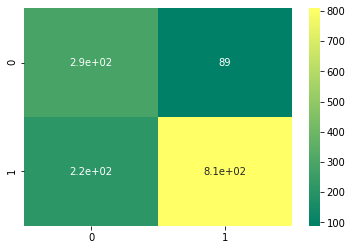

,metrica,valid
0,f1,0.840519
1,recall,0.787731
2,precision,0.900891
3,AUC-ROC,0.855478


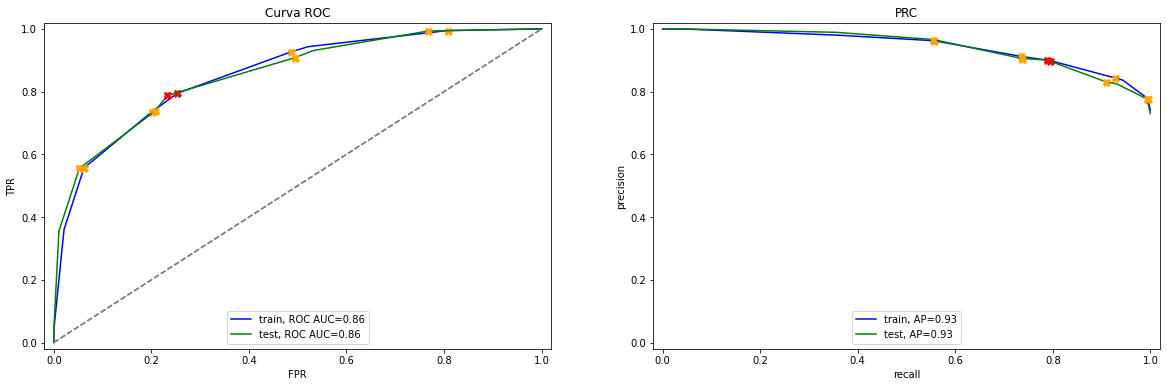

In [96]:
dt = DecisionTreeClassifier(random_state=12345, class_weight="balanced")
hiper_dt = {"max_depth" : range(6, 18, 2),"min_samples_split": range(2, 10, 2), "min_samples_leaf" : range(1, 6, 1), "max_leaf_nodes":[10,20]}
dt_model, f1_metric_dt, recall_metric_dt, precision_metric_dt, auc_roc_metric_dt, result_dt=modelo(dt, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_dt, scoring=r_scorer, cv=5)
result_dt

**observaciones:**

1. El modelo es capaz de predecir los clientes activos en un 79%.
2. La curva AUC-ROC muestra que hay 86% de probabilidad de distinguir entre las 2 clases(clientes activos y clientes inactivos).
3. La precisión del modelo es de un 90%

### Modelo LGBM

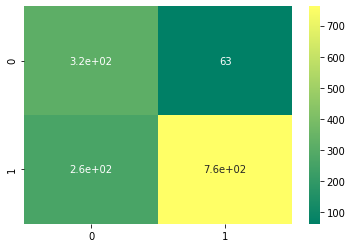

,metrica,valid
0,f1,0.822894
1,recall,0.741967
2,precision,0.923636
3,AUC-ROC,0.860584


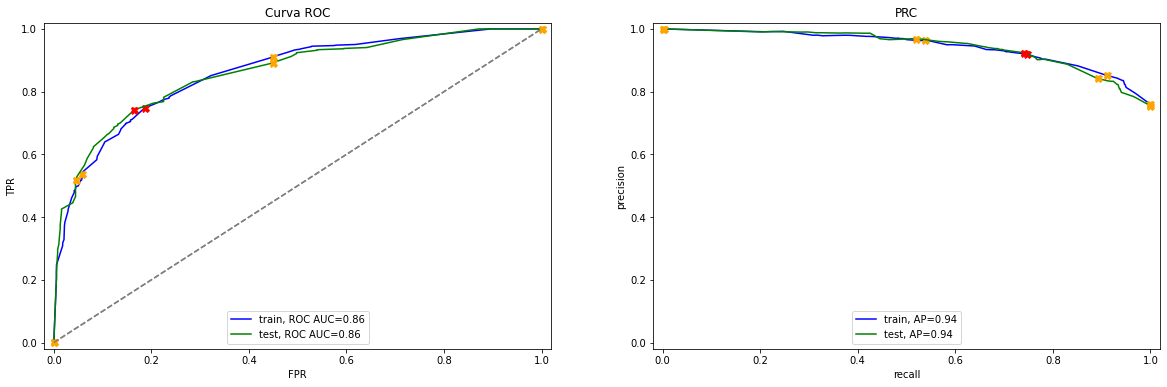

In [97]:
lgbm = LGBMClassifier(random_state=12345, class_weight="balanced")
hiper_lgbm = {"learning_rate": [0.01, 0.05], "max_depth": [4, 6, 10], "n_estimators": [100, 500], "num_leaves": [5, 10, 20]}
lgbm_model, f1_metric_lgbm, recall_metric_lgbm, precision_metric_lgbm, auc_roc_metric_lgbm, result_lgbm=modelo(lgbm, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_lgbm, scoring=r_scorer, cv=5)
result_lgbm

**observaciones:**
1. El modelo es capaz de predecir en un 74% la cantidad de clientes que se mantienen activos.
2. La curva AUC-ROC muestra que el modelo es capaz de diferenciar las clases con una probabilidad de 86%.

### Modelo CatBoost

0:	learn: 0.6857048	total: 54.2ms	remaining: 1.57s
1:	learn: 0.6776013	total: 62.1ms	remaining: 870ms
2:	learn: 0.6714305	total: 69.7ms	remaining: 627ms
3:	learn: 0.6654466	total: 77.4ms	remaining: 503ms
4:	learn: 0.6583385	total: 84.7ms	remaining: 423ms
5:	learn: 0.6521625	total: 91.6ms	remaining: 366ms
6:	learn: 0.6451055	total: 98.5ms	remaining: 323ms
7:	learn: 0.6388474	total: 105ms	remaining: 290ms
8:	learn: 0.6327250	total: 113ms	remaining: 263ms
9:	learn: 0.6256722	total: 120ms	remaining: 239ms
10:	learn: 0.6194999	total: 127ms	remaining: 219ms
11:	learn: 0.6141674	total: 134ms	remaining: 201ms
12:	learn: 0.6086144	total: 142ms	remaining: 185ms
13:	learn: 0.6041074	total: 144ms	remaining: 165ms
14:	learn: 0.5987862	total: 151ms	remaining: 151ms
15:	learn: 0.5940633	total: 159ms	remaining: 139ms
16:	learn: 0.5892169	total: 169ms	remaining: 129ms
17:	learn: 0.5834997	total: 179ms	remaining: 119ms
18:	learn: 0.5789842	total: 189ms	remaining: 109ms
19:	learn: 0.5742070	total: 193ms	

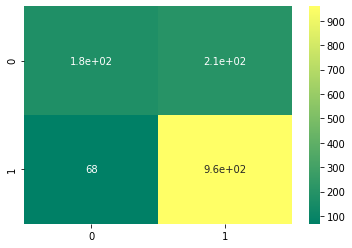

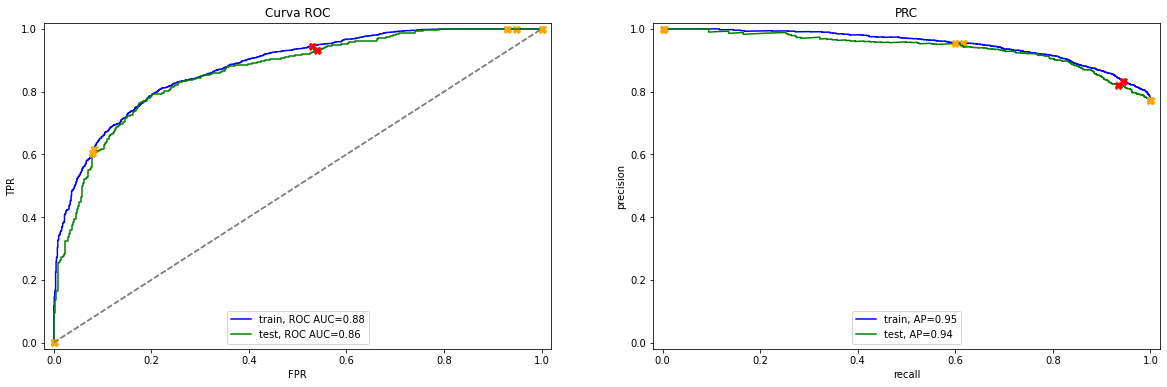

In [98]:
cat = CatBoostClassifier(random_state=12345)
hiper_catboost = {"iterations": [30, 50, 100], "max_depth" : [8, 10, 12], "learning_rate": [0.01, 0.5]}
cat_model, f1_metric_cat, recall_metric_cat, precision_metric_cat, auc_roc_metric_cat, result_cat=modelo(cat, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_catboost, scoring=r_scorer, cv=5)


In [99]:
result_cat 

,metrica,valid
0,f1,0.875000
1,recall,0.933788
2,precision,0.823176
3,AUC-ROC,0.862393


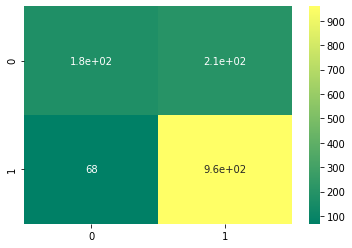

In [102]:
p=cat_model.predict(features_valid)
cm = confusion_matrix(target_valid, p)
sns.heatmap(cm, annot=True, cmap="summer")
plt.show()


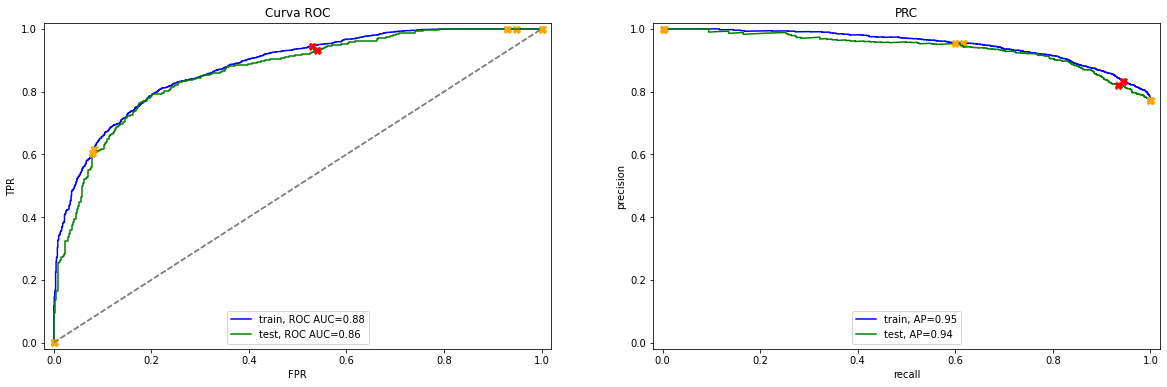

In [100]:
grafica_metrica_modelo(cat_model, features_train, target_train, features_valid, target_valid)

**observaciones:**
1. El modelo es capaz de acertar en 93% que los clientes se mantienen activos.
2. La curva AUC-ROC muestra que hay probabilidad de 86% de que el modelo pueda distinguir entre las clases

### Modelo XGB Classifier


[04:53:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:53:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

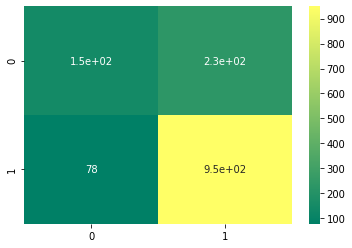

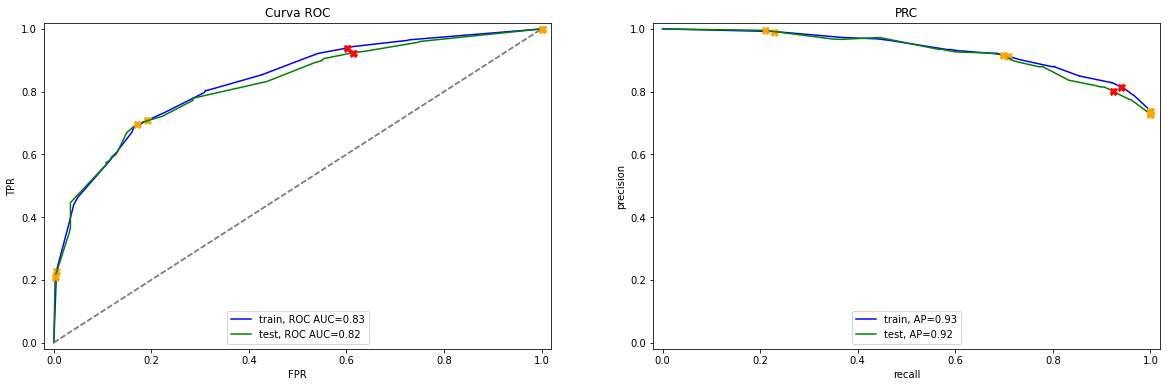

In [103]:
xgb = XGBClassifier(random_state=12345)
hiper_xgb={"n_estimators": [50, 100, 500], "max_depth" : [2, 6, 12], "learning_rate": [0.01, 0.5]}
xgb_model, f1_metric_xgb, recall_metric_xgb, precision_metric_xgb, auc_roc_metric_xgb, result_xgb=modelo(xgb, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_xgb, scoring=r_scorer, cv=5)

In [104]:
result_xgb

,metrica,valid
0,f1,0.858824
1,recall,0.924051
2,precision,0.802198
3,AUC-ROC,0.821914


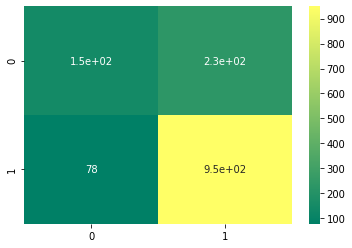

In [105]:
px=xgb_model.predict(features_valid)
cm = confusion_matrix(target_valid, px)
sns.heatmap(cm, annot=True, cmap="summer")
plt.show()

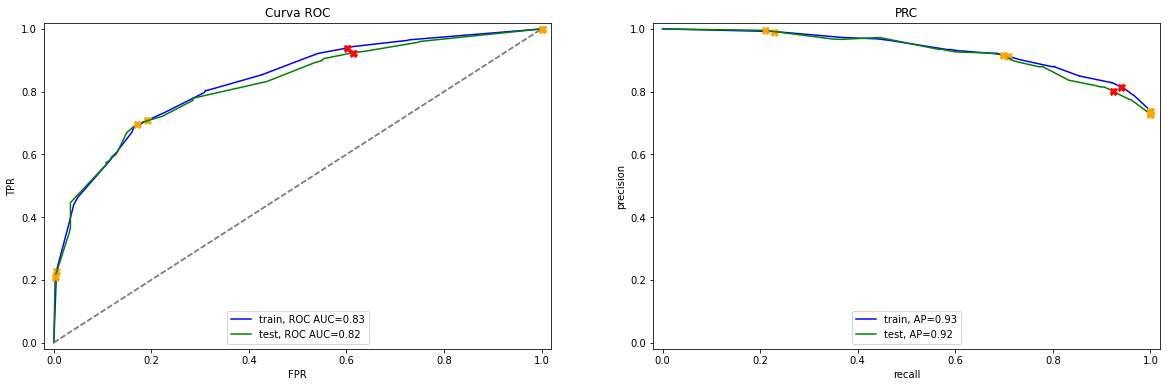

In [106]:
grafica_metrica_modelo(xgb_model, features_train, target_train, features_valid, target_valid)

**observaciones:**
1. El modelo predice en un 92% los valores positivos(clientes activos).
2. La curva AUC-ROC muestra que el modelo tiene la probabilidad de un 82% de distinguir entre las clases.

### Red Neuronal

In [97]:
model_keras = keras.models.Sequential()
model_keras.add(keras.layers.Dense(units=25, input_dim=features_train.shape[1], activation = "relu"))
model_keras.add(keras.layers.Dense(units=10, activation = "relu"))
model_keras.add(keras.layers.Dense(units=1, activation = "sigmoid"))
model_keras.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["acc"])
model_keras.fit(features_train, target_train, epochs=20, verbose=2, validation_data = (features_valid, target_valid))
pred = model_keras.predict(features_valid)
pred

2023-03-07 18:24:44.995669: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
133/133 - 1s - loss: 0.6449 - acc: 0.6589 - val_loss: 0.5847 - val_acc: 0.7296 - 1s/epoch - 9ms/step
Epoch 2/20
133/133 - 0s - loss: 0.5455 - acc: 0.7404 - val_loss: 0.5273 - val_acc: 0.7466 - 390ms/epoch - 3ms/step
Epoch 3/20
133/133 - 0s - loss: 0.5005 - acc: 0.7567 - val_loss: 0.4895 - val_acc: 0.7637 - 376ms/epoch - 3ms/step
Epoch 4/20
133/133 - 0s - loss: 0.4700 - acc: 0.7884 - val_loss: 0.4661 - val_acc: 0.7828 - 362ms/epoch - 3ms/step
Epoch 5/20
133/133 - 0s - loss: 0.4517 - acc: 0.7946 - val_loss: 0.4521 - val_acc: 0.7807 - 378ms/epoch - 3ms/step
Epoch 6/20
133/133 - 0s - loss: 0.4415 - acc: 0.7953 - val_loss: 0.4448 - val_acc: 0.7828 - 383ms/epoch - 3ms/step
Epoch 7/20
133/133 - 0s - loss: 0.4355 - acc: 0.7938 - val_loss: 0.4404 - val_acc: 0.7850 - 372ms/epoch - 3ms/step
Epoch 8/20
133/133 - 0s - loss: 0.4315 - acc: 0.7946 - val_loss: 0.4371 - val_acc: 0.7871 - 369ms/epoch - 3ms/step
Epoch 9/20
133/133 - 0s - loss: 0.4286 - acc: 0.7938 - val_loss: 0.4344 - val_acc: 

array([[0.97091   ],
       [0.94351166],
       [0.9206252 ],
       ...,
       [0.7801661 ],
       [0.93578815],
       [0.98208547]], dtype=float32)

**observaciones:**

1. La exactitud del modelo esta en el orden del 80%.

### Modelo MLP

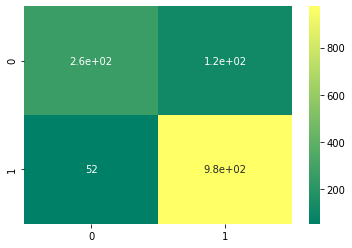

,metrica,valid
0,f1,0.918944
1,recall,0.949367
2,precision,0.890411
3,AUC-ROC,0.908206


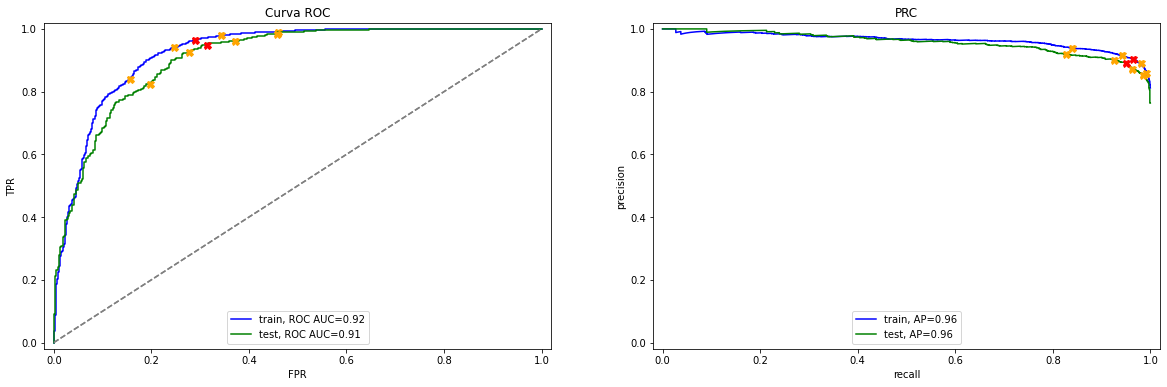

In [107]:
mlp = MLPClassifier(random_state=12345)
hiper_mlp={"hidden_layer_sizes": [(100,50,30)],
    "max_iter": [100, 200, 300],
    "activation": ["logistic", "relu"],
    "solver": ["lbfgs", "sgd"]}
mlp_model, f1_metric_mlp, recall_metric_mlp, precision_metric_mlp, auc_roc_metric_mlp, result_mlp=modelo(mlp, features_train, target_train, features_valid, target_valid, hiperparametros=hiper_mlp, scoring=r_scorer, cv=5)
result_mlp


**observaciones:**
1. El modelo predice en un 100% los valores positivos.
2. La curva AUC-ROC indica que el modelo tiene 73% de probabilidad de diferenciar entre las dos clases.


In [153]:
resultados_1 = pd.DataFrame({"model": ["LogisticRegression", "RandomForestClassifier",  "DecisionTreeClassifier","LGBMClassifier", "CatBoostClassifier", "XgbClassifier", "MLP"],
              "f1": [f1_metric_lr,f1_metric_rf, f1_metric_dt, f1_metric_lgbm, f1_metric_cat, f1_metric_xgb, f1_metric_mlp],
                            "recall" : [recall_metric_lr, recall_metric_rf, recall_metric_dt, recall_metric_lgbm, recall_metric_cat, recall_metric_xgb, recall_metric_mlp],
                            "precision" : [precision_metric_lr, precision_metric_rf, precision_metric_dt, precision_metric_lgbm, precision_metric_cat, precision_metric_xgb, precision_metric_mlp ],
                            "auc-roc": [auc_roc_metric_lr, auc_roc_metric_rf, auc_roc_metric_dt, auc_roc_metric_lgbm, auc_roc_metric_cat, auc_roc_metric_xgb, auc_roc_metric_mlp]})
                           
resultados_1

,model,f1,recall,precision,auc-roc
0,LogisticRegression,0.809498,0.730282,0.907990,0.845364
1,RandomForestClassifier,0.805857,0.723466,0.909425,0.831742
2,DecisionTreeClassifier,0.840519,0.787731,0.900891,0.855478
3,LGBMClassifier,0.822894,0.741967,0.923636,0.860584
4,CatBoostClassifier,0.875000,0.933788,0.823176,0.862393
5,XgbClassifier,0.858824,0.924051,0.802198,0.821914
6,MLP,0.918944,0.949367,0.890411,0.908206


**De la tabla de resultados se observa:**
1. El modelo MLP es el que mejores valores de métricas presenta con 0.91 de AUC-ROC y mayor valor de f1 y recall, de hecho, por la matriz de confusion se aprecia que es el que mejor reproduce los valores verdaderos positivos, es decir, los clientes que se quedaron, sin embargo, este modelo no reproduce tan bien los verdaderos negativos(clientes que se fueron).
2. Los modelos LGBM y CatBoost son los que en segundo lugar mejor reproducen en el conjunto de validación el target, tanto su métrica AUC-ROC (0.86) como f1 (0.88 - 0.82), tienen valores aceptables. De acuerdo a la matriz de confusion el algoritmo LGBM es el que mejor reproduce la clase correspondiente a los verdaderos negativos donde tenemos a los clientes que se fueron. 
3. El modelo Random Forest es el que muestra el desempeño más bajo, seguido muy de cerca por el algoritmo Logistic Regression.
4. Como era de esperarse los modelos con más alto recall (CatBoost, XGBBoost y MLP) son los menos precisos porque aumentan los falsos positivos y viceversa el modelo con mayor precisión (LGBM) tiene menor recall ya que en este caso aumentan los falsos negativos.
5. Se construyó un modelo de red neuronal encontrándose una exactitud de 0.8, lo cual muestra que los modelos MLP, CatBoost y LGBM siguen siendo mejor para este caso de clasificación binaria.

### Evaluación del modelo MLP, CatBoost y LGBM en la muestra de datos test

In [154]:
mlp_model

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50, 30),
              max_iter=100, random_state=12345, solver='lbfgs')

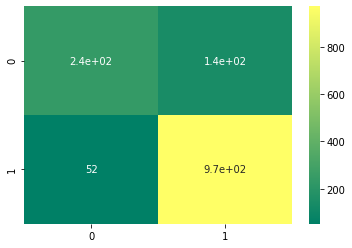

,metrica,valid
0,f1,0.918944
1,recall,0.949367
2,precision,0.890411
3,AUC-ROC,0.908206


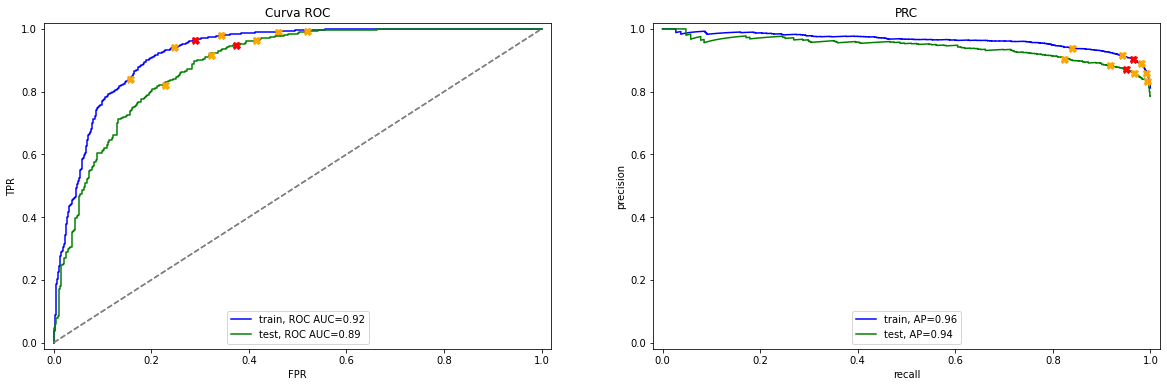

In [108]:
#evaluación del modelo MLP
mlp = MLPClassifier(random_state=12345)
hiper_mlp={"hidden_layer_sizes": [(100,50,30)],
    "max_iter": [100],
    "activation": ["logistic"],
    "solver": ["lbfgs"]}
mlp_model_test, f1_metric_mlp_test, recall_metric_mlp_test, precision_metric_mlp_test, auc_roc_metric_mlp_test, result_mlp_test=modelo(mlp, features_train, target_train, features_test, target_test, hiperparametros=hiper_mlp, scoring=r_scorer, cv=5)
result_mlp

In [156]:
lgbm_model

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=4,
               num_leaves=5, random_state=12345)

[[311  75]
 [269 754]]


,metrica,valid
0,f1,0.814255
1,recall,0.737048
2,precision,0.909530
3,AUC-ROC,0.843109


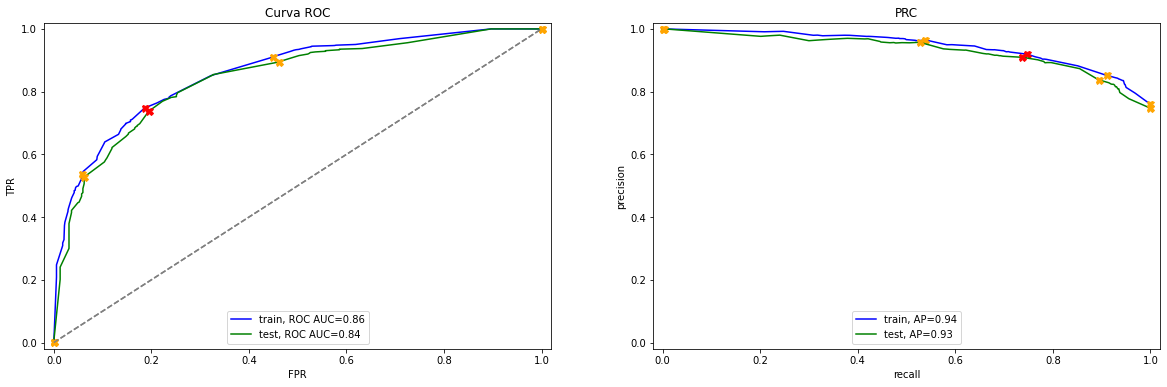

In [157]:
lgbm = LGBMClassifier(random_state=12345, class_weight="balanced")
hiper_lgbm = {"learning_rate": [0.01], "max_depth": [4], "n_estimators": [100], "num_leaves": [5]}
lgbm_model_test, f1_metric_lgbm_test, recall_metric_lgbm_test, precision_metric_lgbm_test, auc_roc_metric_lgbm_test, result_lgbm_test=modelo(lgbm, features_train, target_train, features_test, target_test, hiperparametros=hiper_lgbm, scoring=r_scorer, cv=5)
result_lgbm_test

0:	learn: 0.6857048	total: 7ms	remaining: 693ms
1:	learn: 0.6776013	total: 14.5ms	remaining: 709ms
2:	learn: 0.6714305	total: 21.7ms	remaining: 701ms
3:	learn: 0.6654466	total: 28.7ms	remaining: 689ms
4:	learn: 0.6583385	total: 35.8ms	remaining: 681ms
5:	learn: 0.6521625	total: 43.2ms	remaining: 676ms
6:	learn: 0.6451055	total: 50.4ms	remaining: 670ms
7:	learn: 0.6388474	total: 57.5ms	remaining: 662ms
8:	learn: 0.6327250	total: 64.4ms	remaining: 651ms
9:	learn: 0.6256722	total: 71.2ms	remaining: 641ms
10:	learn: 0.6194999	total: 78ms	remaining: 631ms
11:	learn: 0.6141674	total: 84.8ms	remaining: 622ms
12:	learn: 0.6086144	total: 91.7ms	remaining: 614ms
13:	learn: 0.6041074	total: 94.3ms	remaining: 579ms
14:	learn: 0.5987862	total: 101ms	remaining: 575ms
15:	learn: 0.5940633	total: 109ms	remaining: 570ms
16:	learn: 0.5892169	total: 115ms	remaining: 564ms
17:	learn: 0.5834997	total: 123ms	remaining: 559ms
18:	learn: 0.5789842	total: 130ms	remaining: 553ms
19:	learn: 0.5742070	total: 132m

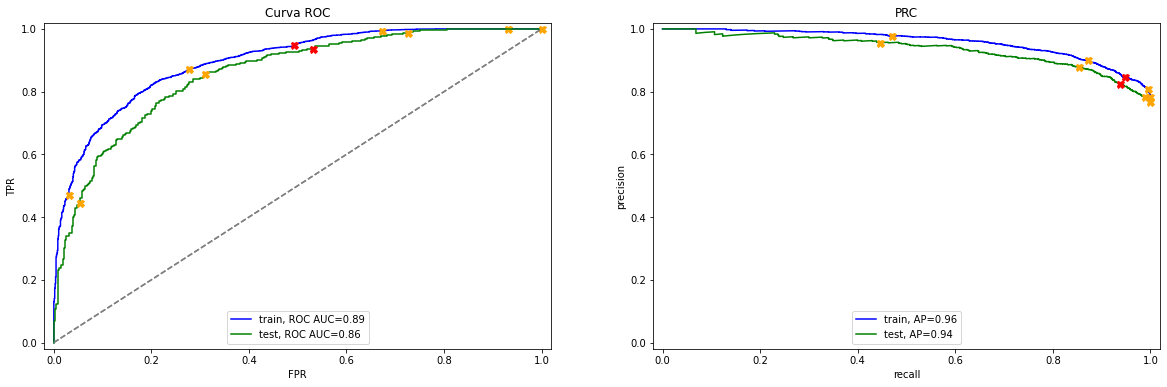

In [160]:
cat = CatBoostClassifier(random_state=12345)
hiper_catboost = {"iterations": [100], "max_depth" : [8], "learning_rate": [0.01]}
cat_model_test, f1_metric_cat_test, recall_metric_cat_test, precision_metric_cat_test, auc_roc_metric_cat_test, result_cat_test=modelo(cat, features_train, target_train, features_test, target_test, hiperparametros=hiper_catboost, scoring=r_scorer, cv=5)


In [162]:
resultado_final = pd.DataFrame({"model" : ["MLP", "CatBoost", "LGBM"],
                                "f1_test": [f1_metric_mlp_test, f1_metric_cat_test, f1_metric_lgbm_test],
                                "recall_test" : [recall_metric_mlp_test, recall_metric_cat_test, recall_metric_lgbm_test],
                                "precision_test" : [precision_metric_mlp_test, precision_metric_cat_test, precision_metric_lgbm_test],
                                "AUC-ROC_test" : [auc_roc_metric_mlp_test, auc_roc_metric_cat_test, auc_roc_metric_lgbm_test],
                                "f1_valid": [f1_metric_mlp, f1_metric_cat, f1_metric_lgbm],
                                "recall_valid" : [recall_metric_mlp, recall_metric_cat, recall_metric_lgbm],
                                "precision_valid" : [precision_metric_mlp, precision_metric_cat, precision_metric_lgbm],
                                "AUC-ROC_valid" : [auc_roc_metric_mlp, auc_roc_metric_cat, auc_roc_metric_lgbm],
                                })
resultado_final

,model,f1_test,recall_test,precision_test,AUC-ROC_test,f1_valid,recall_valid,precision_valid,AUC-ROC_valid
0,MLP,0.908326,0.949169,0.870852,0.886228,0.918944,0.949367,0.890411,0.908206
1,CatBoost,0.877402,0.937439,0.824592,0.857174,0.875000,0.933788,0.823176,0.862393
2,LGBM,0.814255,0.737048,0.909530,0.843109,0.822894,0.741967,0.923636,0.860584


**Observaciones:**

1. Los resultados de AUC-ROC en la muestra de prueba, para los 3 modelos, fue ligeramente menor a lo obtenido en la prueba de validación, realmente los resultados son muy parecidos.
2. Las otras métricas muestran el mismo comportamiento, un leve descenso en la muestra de prueba respecto a la de validación, sin embargo, se mantienen en el mismo orden.

## Conclusiones

1. El departamento de marketing de la empresa **Interconnet**, inicialmente proporcionó 4 DataFrame: Contratos(7043,8), personal(7043, 5), teléfono(6361, 2) e internet(5517, 8).
2. La información suministrada no tenía datos ausentes ni datos duplicados.
3. Se creo una columna en telefono y una en internet para conocer si estaba activo el usuario con ese servicio.
4. Se renombraron las columnas de los 4 DataFrame por cuanto no cumplian con la regla.
5. Se fusionaron las 4 tablas a través de la columna "customer_id", quedando un solo DataFrame(7043, 22 columnas)
6. Se transformaron a formato datetime las columnas de "begin_date" y "end_date" para hacer cálculos de período de tiempo.
7. Se calculó la "antiguedad" de los clientes que terminaron contrato con Interconnet.
8. Se creó la columna "target" con valores de 0(inactivos) y 1(activos) para indicar el status de los clientes.
9. Se eliminaron las columnas "customer_id", "begin_date" y "end_date" por cuanto no aportarán mayor información al modelo de machine learning, quedando un DataFrame de 7043, 21 columnas.
10. Se realizó el análisis exploratorio de los datos mediante gráficos de boxplots y violin para las variables numéricas y se realizo la evaluación por chi2 de las variables categóricas.
11. Se transformaron a numéricas mediante One-Hot las variables categóricas, resultando un total de 25 columnas.
12. Se estandarizaron las columnas "monthly_charges", "total_charges" y "antiguedad".
13. Se hizo el split del conjunto de datos: 60% datos de entrenamiento, 20% datos para validación y 20% datos para prueba.
14. Se creó una función para la evaluación de las métricas: f1, recall, precision, AUC-ROC.
15. Se creó una función para generar gráficos de AUC-ROC y PRC.
16. Se creo una función para la evaluación del modelo con ajuste de hiperparámetros.
17. Se evaluaron los modelos: Logistic Regression, Random Forest Classifier, Decision Tree Classifier, LGBM Classifier, CatBoost Classifier, XGB Classifier, MLP y red neuronal.
18. Los resultados muestran que el modelo que tuvo mejor desempeño fue el MLP seguido de CatBoost y LGBM y el de menor desempeño Random Forest Classifier y Logistic Regression.
19. Los modelos MLP, CatBoost y LGBM se evaluaron con los datos de prueba y mantuvieron su desempeño, encontrándose que hay en promedio 87% de probabilidad de que los modelos puedas distinguir los clientes que se fueron y los que se mantienen activos.
20. El algoritmo LGBM es el que mejor modela los clientes que se fueron o inactivos.

# Informe

**1. Qué pasos del plan se realizaron y que pasos se omitieron?**

De acuerdo al plan se realizó:
1. La revisión de la información a fin de buscar datos faltantes y duplicados. Así mismo se realizó la unión de las 4 tablas para crear una sola. Se verificaron las unidades de las variables, la nomenclatura de los nombres y después de la unión se rectificaron los datos faltantes. Finalmente, en esta etapa, se eliminaron las varibles de identificador de clientes y fechas.
2. Se realizó el análisis exploratorio de los datos, para las variables categóricas se implementaron las tablas de contingencia y el estadístico chi2 (esto no estaba previsto en el plan original) y para las variables numéricas se realizaron gráficos violin y boxplots para su análisis y se determinó el índice de correlación.
3. Se Aplicó codificación One-Hot para transformar las características categóricas en numéricas(casi todas son de yes or no, por lo que no se deben agregar muchas columnas): pd.get_dummies(data, drop_first=True)
4. Se realizó el escalado de las features por el desequilibrio que hay: scaler = StandardScaler()
5. Se realizó el split de features y target en datos de entrenamiento(60%), validación(20%) y prueba(20%): train_test_split()
6. Definí una función para las métricas que mejore la eficiencia del modelo (F1,recall, precision, AUC-ROC, matriz de confusión). Así mismo se tomó de proyecto pasado la función para graficar el AUC-ROC y recall vs precision (no estaba previsto en el plan). Finalmente se construyó una función para evaluar el modelo.
7. Entrene diferentes modelos(LogisticRegression, RandomForest, DecisionTree, XGB, CatBoost, LGBMy MPL) con ajuste de hiperparámetros y evalúe en los últimos 3 en el conjunto de datos de validación y prueba.

Del plan original no omití ningún paso, al contrario adicione algunos como: 

1. Tablas de contingencia y chi2.
2. Gráficos violin.
2. Matriz de confusion.
3. Modelos CatBoost, XGB y MPL.

**2. Que dificultades encontraste y como lograste resolverlas?**
1. La presencia de datos faltantes en la columna fecha.
2. La definición de los hiperparámetros y sus rangos en los modelos, para ello tuve que ir al internet para profundizar un poco más.
3. La generación de la matriz confusion en los modelos CatBoost y MPL ya que los arrojaba dentro de su cuadro de corrida y no quedaban visibles, por lo que fuera tuve que hacer algunos cálculos.

**3. Cuáles fueron algunos de los pasos claves para resolver la tarea?**
1. La definición del target.
2. El análisis exploratorio.
3. La transformación de las variables categóricas.
4. El split de las variables en train, valid y test.
5. El modelado.

**4. Cuál es tu modelo final y que nivel de calidad tiene=**
1. MPL y CatBoost con AUC-ROC de 91 y 88% respectivamente.